# DAT450 Project: Image Captioning - Group 35

In [ ]:
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

import os
import zipfile

from sklearn.model_selection import train_test_split

import spacy
from collections import Counter
import nltk
#from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
import re
import random
import numpy as np
#nltk.download('stopwords')
nltk.download('punkt')

import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tqdm import tqdm
from PIL import Image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Reshape, concatenate
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.sequence import pad_sequences

import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wanqiuwang","key":"959ada48cb677f0466c269a192a9ca7d"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list
! kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [02:11<00:00, 91.3MB/s]
100% 8.16G/8.16G [02:11<00:00, 66.6MB/s]


In [ ]:
os.makedirs('data' , exist_ok=True)
target_directory = '/content/data'

with zipfile.ZipFile('flickr-image-dataset.zip' , 'r') as zip_ref:
  zip_ref.extractall(target_directory)

# 1 Process the dataset

In [ ]:
data = pd.read_csv('/content/data/flickr30k_images/results.csv', sep = '|')
data = data.rename(columns={'image_name': 'img', ' comment_number' : 'no', ' comment' : 'caption'})

In [ ]:
img_id = list(data['img'].unique())

### Used to recover the original train-test split
with open('/content/drive/MyDrive/train_img_features', 'rb') as fp:
    train_img = pickle.load(fp)
train_2_id = train_img.keys()
test_2_id = [id for id in img_id if id not in train_2_id]

train_df = data[data['img'].isin(train_2_id)]
test_df =  data[data['img'].isin(test_2_id)]

In [ ]:
train_df.reset_index(inplace = True, drop = True)
test_df.reset_index(inplace = True, drop = True)

## 1.1 Create vocabulary

In [ ]:
start = '<start>'
end = '<end>'
unknown = '<UNKNOWN>'
pad = '<PAD>'

class AnnPreprocessor:
    def __init__(self, tokenizer = word_tokenize, max_voc_size= None, max_len=None):
        self.tokenizer = tokenizer
        self.max_voc_size = max_voc_size
        self.max_len = max_len

    def build_vocabulary(self, data):
      self.vocab = {}
      self.reverse = {}

      self.vocab[pad] = 0
      self.vocab[start] = 1
      self.vocab[end] = 2
      self.vocab[unknown] = 3

      self.reverse[0] = pad
      self.reverse[1] = start
      self.reverse[2] = end
      self.reverse[3] = unknown

      #if self.max_len == None:
       # self.max_len = 0

      # Read the captions
      captions = data['caption']
      all_tokens = []
      for i in range(len(captions)):
        text = str(captions[i])
        tokens = self.tokenizer(text.lower())
        all_tokens.extend(tokens)
        #if self.max_len == None:
          #if len(tokens)+2 > self.max_len:
            #self.max_len = len(tokens)+2

      word_counts = Counter(all_tokens)
      # Remove uncommon words
      words = [word for word, count in word_counts.items() if count >= 10]

      # Build the vocabulary
      for i, word in enumerate(words):
        self.vocab[word] = i+4
        self.reverse[i+4] = word


    def voc_size(self):
      self.voc_sz = len(self.vocab)
      return self.voc_sz

    def max_length(self):
      return self.max_len

    def encode(self, X):# Encode a batch of the captions
      self.encoded_data = []
      for x in X:
        encoded = []
        encoded.append(self.vocab[start])
        x = str(x)
        x_tokens = self.tokenizer(x.lower())
        x_encoded = [self.vocab.get(word,3) for word in x_tokens]
        if (len(x_encoded) > self.max_len):
          x_encoded = x_encoded[:self.max_len]
        encoded.extend(x_encoded)
        encoded.append(self.vocab[end])
        self.encoded_data.append(encoded)
      # Pad the encoded data
      #self.encoded_data = [x + [self.vocab[pad]] * (self.max_len - len(x)) for x in self.encoded_data]

      return self.encoded_data
      #return torch.Tensor(self.encoded_data)

    def vocabulary(self):
      return self.vocab

## 1.2 Use pre-trained CNN encoder to encode images

In [ ]:
def encode_cnn(data, model, img_size, img_path):
  encode_model = Model(inputs=model.input, outputs=model.layers[-2].output)# Only extract feature vector
  img_ids = list(data['img'].unique())
  image_features = {}
  for image in tqdm(img_ids):
    #img = load_img(img_path+image, target_size = (img_size,img_size))
    img = Image.open(img_path + image)
    img = img.resize((img_size, img_size))
    img = np.array(img)
    img = img/255
    img_expanded = np.expand_dims(img, axis=0)
    features = encode_model.predict(img_expanded)
    image_features[image] = features

  return image_features

# 2 Create the data loader

In [ ]:
# Prepare the data
# Load the dataset: images ad annotations
# Encode the annotations

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_feature, data, batch_size, preprocessor,train_data,transform=None, shuffle=True):
        """
        Arguments:

        """
        self.data = data.copy()
        self.img_feature = img_feature
        self.batch_size = batch_size
        self.preprocessor = preprocessor
        self.transform = transform
        self.shuffle = shuffle
        # Build the vocabulary
        self.preprocessor.build_vocabulary(train_data)
        self.vocab = self.preprocessor.vocabulary()
        self.max_len = self.preprocessor.max_length() + 2
        self.vocab_sz = self.preprocessor.voc_size()

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, idx):
      # train_df.iloc[1*100:2*100]
        batches = self.data[idx*self.batch_size:(idx+1)*self.batch_size]
        X1,X2, y = self.__getdata(batches)
        return (X1,X2), y

    def __getdata(self, batches):
      # Generate data contaning batch_size samples
      X1, X2, y = [], [], []
      img_ids = list(batches['img'].unique())

      for id in img_ids:
        # Image feature
        feature = self.img_feature[id][0]
        captions = list(batches[batches['img'] == id]['caption'])
        encoded_cap = self.preprocessor.encode(captions)
        for cap in encoded_cap:
          for i in range(1, len(cap)):
            curr_seq = cap[:i]
            next_word = cap[i]
            # Pad the input sequence
            curr_seq = [curr_seq + [self.vocab[pad]] * (self.max_len - len(curr_seq))][0]
            #curr_seq = pad_sequences([curr_seq], maxlen=self.max_len)[0]
            label = to_categorical(next_word, num_classes = self.vocab_sz)#one-hot encoding
            X1.append(feature) #image features
            X2.append(curr_seq) # current sequence
            y.append(label) # label is the next word by giving current sequence

      return np.array(X1), np.array(X2), np.array(y)

    def on_epoch_end(self):
      # This function will be called at the end of every epoch by the fit method.
      # shuffle the dataset in this function to make some randomness.
        if self.shuffle:
            self.data = self.data.sample(frac=1).reset_index(drop=True)

# 3 Define LSTM decoder

In [ ]:
#img_fe_dim: the dimension of the input image feature vector
#cap_dim: the dimension of the input caption vector
#vocab_sz: the output dimension
def decoder_model(img_fe_dim, cap_dim, vocab_sz, embedding_dim=256):
  # image feature input layer
  input_1 = Input(shape = (img_fe_dim,))

  # caption feature input layer
  input_2 = Input(shape = (cap_dim,))

  # Processing image features
  img_fe = Dense(256, activation='relu')(input_1)
  img_fe_re = Reshape((1,256), input_shape = (256,))(img_fe)

  # Processing caption features
  cap_fe = Embedding(vocab_sz, embedding_dim, mask_zero=False)(input_2)

  # concatenate two features
  combined_fe = concatenate([img_fe_re, cap_fe], axis=1)

  # lstm layer
  cap_lstm = LSTM(256)(combined_fe)

  # more layers
  layer = Dropout(0.5)(cap_lstm)
  layer = add([layer, img_fe])
  layer = Dense(128, activation='relu')(layer)
  layer = Dropout(0.5)(layer)
  # output layer
  output = Dense(vocab_sz, activation='softmax')(layer)

  model = Model(inputs=[input_1, input_2], outputs=output)
  model.compile(loss='categorical_crossentropy', optimizer='adam')

  return model

# 4 Training

## 4.1 Encode image features using pre-trained CNN encoder

In [ ]:
model = DenseNet201()
img_size = 224
img_path = '/content/data/flickr30k_images/flickr30k_images/flickr30k_images/'

image_features = encode_cnn(train_df[0:8000], model, img_size, img_path)

82524592/82524592 [==============================] - 1s 0us/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


  0%|          | 1/200 [00:06<20:27,  6.17s/it]

1/1 [==============================] - 0s 301ms/step


  1%|          | 2/200 [00:06<09:08,  2.77s/it]

1/1 [==============================] - 0s 265ms/step


  2%|▏         | 3/200 [00:06<05:34,  1.70s/it]

1/1 [==============================] - 0s 257ms/step


  2%|▏         | 4/200 [00:07<03:47,  1.16s/it]

1/1 [==============================] - 0s 252ms/step


  2%|▎         | 5/200 [00:07<02:54,  1.12it/s]

1/1 [==============================] - 0s 254ms/step


  3%|▎         | 6/200 [00:08<02:17,  1.41it/s]

1/1 [==============================] - 0s 254ms/step


  4%|▎         | 7/200 [00:08<01:53,  1.71it/s]

1/1 [==============================] - 0s 245ms/step


  4%|▍         | 8/200 [00:08<01:41,  1.90it/s]

1/1 [==============================] - 0s 270ms/step


  4%|▍         | 9/200 [00:09<01:31,  2.09it/s]

1/1 [==============================] - 0s 258ms/step


  5%|▌         | 10/200 [00:09<01:26,  2.20it/s]

1/1 [==============================] - 0s 258ms/step


  6%|▌         | 11/200 [00:10<01:23,  2.27it/s]

1/1 [==============================] - 0s 251ms/step


  6%|▌         | 12/200 [00:10<01:16,  2.44it/s]

1/1 [==============================] - 0s 258ms/step


  6%|▋         | 13/200 [00:10<01:16,  2.44it/s]

1/1 [==============================] - 0s 268ms/step


  7%|▋         | 14/200 [00:11<01:16,  2.42it/s]

1/1 [==============================] - 0s 246ms/step


  8%|▊         | 15/200 [00:11<01:11,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


  8%|▊         | 16/200 [00:11<01:12,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


  8%|▊         | 17/200 [00:12<01:10,  2.59it/s]

1/1 [==============================] - 0s 259ms/step


  9%|▉         | 18/200 [00:12<01:11,  2.55it/s]

1/1 [==============================] - 0s 275ms/step


 10%|▉         | 19/200 [00:13<01:09,  2.60it/s]

1/1 [==============================] - 0s 272ms/step


 10%|█         | 20/200 [00:13<01:07,  2.66it/s]

1/1 [==============================] - 0s 259ms/step


 10%|█         | 21/200 [00:13<01:09,  2.59it/s]

1/1 [==============================] - 0s 268ms/step


 11%|█         | 22/200 [00:14<01:09,  2.55it/s]

1/1 [==============================] - 0s 396ms/step


 12%|█▏        | 23/200 [00:14<01:14,  2.36it/s]

1/1 [==============================] - 0s 448ms/step


 12%|█▏        | 24/200 [00:15<01:22,  2.14it/s]

1/1 [==============================] - 0s 411ms/step


 12%|█▎        | 25/200 [00:15<01:25,  2.05it/s]

1/1 [==============================] - 0s 390ms/step


 13%|█▎        | 26/200 [00:16<01:25,  2.03it/s]

1/1 [==============================] - 0s 413ms/step


 14%|█▎        | 27/200 [00:17<01:40,  1.72it/s]

1/1 [==============================] - 0s 428ms/step


 14%|█▍        | 28/200 [00:17<01:38,  1.74it/s]

1/1 [==============================] - 0s 412ms/step


 14%|█▍        | 29/200 [00:18<01:48,  1.58it/s]

1/1 [==============================] - 0s 414ms/step


 15%|█▌        | 30/200 [00:19<01:54,  1.49it/s]

1/1 [==============================] - 0s 420ms/step


 16%|█▌        | 31/200 [00:19<01:47,  1.57it/s]

1/1 [==============================] - 0s 334ms/step


 16%|█▌        | 32/200 [00:20<01:38,  1.71it/s]

1/1 [==============================] - 0s 267ms/step


 16%|█▋        | 33/200 [00:20<01:29,  1.87it/s]

1/1 [==============================] - 0s 244ms/step


 17%|█▋        | 34/200 [00:21<01:22,  2.02it/s]

1/1 [==============================] - 0s 258ms/step


 18%|█▊        | 35/200 [00:21<01:17,  2.13it/s]

1/1 [==============================] - 0s 252ms/step


 18%|█▊        | 36/200 [00:21<01:10,  2.32it/s]

1/1 [==============================] - 0s 265ms/step


 18%|█▊        | 37/200 [00:22<01:06,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 19%|█▉        | 38/200 [00:22<01:05,  2.46it/s]

1/1 [==============================] - 0s 249ms/step


 20%|█▉        | 39/200 [00:22<01:05,  2.46it/s]

1/1 [==============================] - 0s 258ms/step


 20%|██        | 40/200 [00:23<01:02,  2.56it/s]

1/1 [==============================] - 0s 265ms/step


 20%|██        | 41/200 [00:23<01:03,  2.50it/s]

1/1 [==============================] - 0s 248ms/step


 21%|██        | 42/200 [00:24<01:00,  2.62it/s]

1/1 [==============================] - 0s 251ms/step


 22%|██▏       | 43/200 [00:24<01:01,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


 22%|██▏       | 44/200 [00:24<00:58,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 22%|██▎       | 45/200 [00:25<00:59,  2.60it/s]

1/1 [==============================] - 0s 268ms/step


 23%|██▎       | 46/200 [00:25<00:57,  2.67it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██▎       | 47/200 [00:25<00:58,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


 24%|██▍       | 48/200 [00:26<00:59,  2.57it/s]

1/1 [==============================] - 0s 261ms/step


 24%|██▍       | 49/200 [00:26<00:57,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


 25%|██▌       | 50/200 [00:27<00:58,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


 26%|██▌       | 51/200 [00:27<00:56,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


 26%|██▌       | 52/200 [00:27<00:57,  2.56it/s]

1/1 [==============================] - 0s 258ms/step


 26%|██▋       | 53/200 [00:28<00:55,  2.66it/s]

1/1 [==============================] - 0s 272ms/step


 27%|██▋       | 54/200 [00:28<00:55,  2.61it/s]

1/1 [==============================] - 0s 261ms/step


 28%|██▊       | 55/200 [00:29<00:53,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 28%|██▊       | 56/200 [00:29<00:51,  2.79it/s]

1/1 [==============================] - 0s 267ms/step


 28%|██▊       | 57/200 [00:29<00:50,  2.81it/s]

1/1 [==============================] - 0s 257ms/step


 29%|██▉       | 58/200 [00:30<00:50,  2.83it/s]

1/1 [==============================] - 0s 398ms/step


 30%|██▉       | 59/200 [00:30<01:07,  2.08it/s]

1/1 [==============================] - 0s 403ms/step


 30%|███       | 60/200 [00:31<01:08,  2.03it/s]

1/1 [==============================] - 0s 434ms/step


 30%|███       | 61/200 [00:32<01:19,  1.74it/s]

1/1 [==============================] - 0s 430ms/step


 31%|███       | 62/200 [00:32<01:27,  1.57it/s]

1/1 [==============================] - 0s 416ms/step


 32%|███▏      | 63/200 [00:33<01:22,  1.66it/s]

1/1 [==============================] - 0s 437ms/step


 32%|███▏      | 64/200 [00:34<01:29,  1.52it/s]

1/1 [==============================] - 0s 404ms/step


 32%|███▎      | 65/200 [00:34<01:23,  1.62it/s]

1/1 [==============================] - 0s 412ms/step


 33%|███▎      | 66/200 [00:35<01:19,  1.69it/s]

1/1 [==============================] - 0s 330ms/step


 34%|███▎      | 67/200 [00:35<01:13,  1.80it/s]

1/1 [==============================] - 0s 271ms/step


 34%|███▍      | 68/200 [00:36<01:07,  1.96it/s]

1/1 [==============================] - 0s 250ms/step


 34%|███▍      | 69/200 [00:36<01:02,  2.08it/s]

1/1 [==============================] - 0s 245ms/step


 35%|███▌      | 70/200 [00:36<00:56,  2.30it/s]

1/1 [==============================] - 0s 255ms/step


 36%|███▌      | 71/200 [00:37<00:55,  2.33it/s]

1/1 [==============================] - 0s 264ms/step


 36%|███▌      | 72/200 [00:37<00:53,  2.37it/s]

1/1 [==============================] - 0s 260ms/step


 36%|███▋      | 73/200 [00:38<00:50,  2.51it/s]

1/1 [==============================] - 0s 252ms/step


 37%|███▋      | 74/200 [00:38<00:50,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


 38%|███▊      | 75/200 [00:38<00:47,  2.62it/s]

1/1 [==============================] - 0s 268ms/step


 38%|███▊      | 76/200 [00:39<00:48,  2.54it/s]

1/1 [==============================] - 0s 243ms/step


 38%|███▊      | 77/200 [00:39<00:46,  2.67it/s]

1/1 [==============================] - 0s 256ms/step


 39%|███▉      | 78/200 [00:39<00:44,  2.74it/s]

1/1 [==============================] - 0s 265ms/step


 40%|███▉      | 79/200 [00:40<00:45,  2.66it/s]

1/1 [==============================] - 0s 254ms/step


 40%|████      | 80/200 [00:40<00:46,  2.60it/s]

1/1 [==============================] - 0s 247ms/step


 40%|████      | 81/200 [00:41<00:46,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 41%|████      | 82/200 [00:41<00:46,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


 42%|████▏     | 83/200 [00:41<00:44,  2.64it/s]

1/1 [==============================] - 0s 270ms/step


 42%|████▏     | 84/200 [00:42<00:43,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 42%|████▎     | 85/200 [00:42<00:41,  2.75it/s]

1/1 [==============================] - 0s 251ms/step


 43%|████▎     | 86/200 [00:42<00:42,  2.66it/s]

1/1 [==============================] - 0s 402ms/step


 44%|████▎     | 87/200 [00:43<00:52,  2.14it/s]

1/1 [==============================] - 0s 246ms/step


 44%|████▍     | 88/200 [00:43<00:47,  2.35it/s]

1/1 [==============================] - 0s 267ms/step


 44%|████▍     | 89/200 [00:44<00:44,  2.48it/s]

1/1 [==============================] - 0s 263ms/step


 45%|████▌     | 90/200 [00:44<00:44,  2.47it/s]

1/1 [==============================] - 0s 245ms/step


 46%|████▌     | 91/200 [00:45<00:41,  2.62it/s]

1/1 [==============================] - 0s 270ms/step


 46%|████▌     | 92/200 [00:45<00:40,  2.67it/s]

1/1 [==============================] - 0s 315ms/step


 46%|████▋     | 93/200 [00:45<00:40,  2.61it/s]

1/1 [==============================] - 0s 436ms/step


 47%|████▋     | 94/200 [00:46<00:53,  1.99it/s]

1/1 [==============================] - 0s 423ms/step


 48%|████▊     | 95/200 [00:47<01:01,  1.71it/s]

1/1 [==============================] - 0s 389ms/step


 48%|████▊     | 96/200 [00:48<01:06,  1.57it/s]

1/1 [==============================] - 0s 395ms/step


 48%|████▊     | 97/200 [00:48<01:09,  1.47it/s]

1/1 [==============================] - 0s 440ms/step


 49%|████▉     | 98/200 [00:49<01:05,  1.56it/s]

1/1 [==============================] - 0s 433ms/step


 50%|████▉     | 99/200 [00:49<01:02,  1.62it/s]

1/1 [==============================] - 0s 416ms/step


 50%|█████     | 100/200 [00:50<00:59,  1.69it/s]

1/1 [==============================] - 1s 913ms/step


 50%|█████     | 101/200 [00:51<01:12,  1.37it/s]

1/1 [==============================] - 0s 258ms/step


 51%|█████     | 102/200 [00:52<01:03,  1.55it/s]

1/1 [==============================] - 0s 251ms/step


 52%|█████▏    | 103/200 [00:52<00:54,  1.79it/s]

1/1 [==============================] - 0s 276ms/step


 52%|█████▏    | 104/200 [00:52<00:47,  2.00it/s]

1/1 [==============================] - 0s 257ms/step


 52%|█████▎    | 105/200 [00:53<00:42,  2.22it/s]

1/1 [==============================] - 0s 259ms/step


 53%|█████▎    | 106/200 [00:53<00:41,  2.28it/s]

1/1 [==============================] - 0s 270ms/step


 54%|█████▎    | 107/200 [00:53<00:38,  2.42it/s]

1/1 [==============================] - 0s 258ms/step


 54%|█████▍    | 108/200 [00:54<00:35,  2.56it/s]

1/1 [==============================] - 0s 249ms/step


 55%|█████▍    | 109/200 [00:54<00:34,  2.67it/s]

1/1 [==============================] - 0s 258ms/step


 55%|█████▌    | 110/200 [00:54<00:32,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


 56%|█████▌    | 111/200 [00:55<00:33,  2.65it/s]

1/1 [==============================] - 0s 258ms/step


 56%|█████▌    | 112/200 [00:55<00:34,  2.57it/s]

1/1 [==============================] - 0s 257ms/step


 56%|█████▋    | 113/200 [00:56<00:34,  2.55it/s]

1/1 [==============================] - 0s 243ms/step


 57%|█████▋    | 114/200 [00:56<00:32,  2.68it/s]

1/1 [==============================] - 0s 269ms/step


 57%|█████▊    | 115/200 [00:56<00:32,  2.61it/s]

1/1 [==============================] - 0s 255ms/step


 58%|█████▊    | 116/200 [00:57<00:31,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 58%|█████▊    | 117/200 [00:57<00:30,  2.75it/s]

1/1 [==============================] - 0s 269ms/step


 59%|█████▉    | 118/200 [00:57<00:29,  2.77it/s]

1/1 [==============================] - 0s 265ms/step


 60%|█████▉    | 119/200 [00:58<00:28,  2.81it/s]

1/1 [==============================] - 0s 251ms/step


 60%|██████    | 120/200 [00:58<00:29,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 60%|██████    | 121/200 [00:58<00:28,  2.74it/s]

1/1 [==============================] - 0s 256ms/step


 61%|██████    | 122/200 [00:59<00:27,  2.80it/s]

1/1 [==============================] - 0s 250ms/step


 62%|██████▏   | 123/200 [00:59<00:26,  2.85it/s]

1/1 [==============================] - 0s 263ms/step


 62%|██████▏   | 124/200 [00:59<00:26,  2.84it/s]

1/1 [==============================] - 0s 265ms/step


 62%|██████▎   | 125/200 [01:00<00:26,  2.87it/s]

1/1 [==============================] - 0s 254ms/step


 63%|██████▎   | 126/200 [01:00<00:27,  2.73it/s]

1/1 [==============================] - 0s 265ms/step


 64%|██████▎   | 127/200 [01:01<00:26,  2.77it/s]

1/1 [==============================] - 0s 377ms/step


 64%|██████▍   | 128/200 [01:01<00:28,  2.55it/s]

1/1 [==============================] - 0s 436ms/step


 64%|██████▍   | 129/200 [01:02<00:31,  2.27it/s]

1/1 [==============================] - 0s 414ms/step


 65%|██████▌   | 130/200 [01:02<00:38,  1.82it/s]

1/1 [==============================] - 0s 417ms/step


 66%|██████▌   | 131/200 [01:03<00:37,  1.82it/s]

1/1 [==============================] - 0s 392ms/step


 66%|██████▌   | 132/200 [01:04<00:37,  1.83it/s]

1/1 [==============================] - 0s 413ms/step


 66%|██████▋   | 133/200 [01:04<00:41,  1.63it/s]

1/1 [==============================] - 0s 425ms/step


 67%|██████▋   | 134/200 [01:05<00:43,  1.51it/s]

1/1 [==============================] - 0s 397ms/step


 68%|██████▊   | 135/200 [01:06<00:45,  1.44it/s]

1/1 [==============================] - 0s 373ms/step


 68%|██████▊   | 136/200 [01:07<00:45,  1.39it/s]

1/1 [==============================] - 0s 280ms/step


 68%|██████▊   | 137/200 [01:07<00:39,  1.58it/s]

1/1 [==============================] - 0s 273ms/step


 69%|██████▉   | 138/200 [01:07<00:34,  1.80it/s]

1/1 [==============================] - 0s 270ms/step


 70%|██████▉   | 139/200 [01:08<00:31,  1.93it/s]

1/1 [==============================] - 0s 247ms/step


 70%|███████   | 140/200 [01:08<00:29,  2.07it/s]

1/1 [==============================] - 0s 257ms/step


 70%|███████   | 141/200 [01:09<00:27,  2.18it/s]

1/1 [==============================] - 0s 252ms/step


 71%|███████   | 142/200 [01:09<00:24,  2.36it/s]

1/1 [==============================] - 0s 260ms/step


 72%|███████▏  | 143/200 [01:09<00:22,  2.49it/s]

1/1 [==============================] - 0s 253ms/step


 72%|███████▏  | 144/200 [01:10<00:21,  2.62it/s]

1/1 [==============================] - 0s 254ms/step


 72%|███████▎  | 145/200 [01:10<00:21,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 73%|███████▎  | 146/200 [01:10<00:20,  2.64it/s]

1/1 [==============================] - 0s 260ms/step


 74%|███████▎  | 147/200 [01:11<00:19,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


 74%|███████▍  | 148/200 [01:11<00:20,  2.60it/s]

1/1 [==============================] - 0s 258ms/step


 74%|███████▍  | 149/200 [01:12<00:19,  2.55it/s]

1/1 [==============================] - 0s 272ms/step


 75%|███████▌  | 150/200 [01:12<00:19,  2.62it/s]

1/1 [==============================] - 0s 263ms/step


 76%|███████▌  | 151/200 [01:12<00:18,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 76%|███████▌  | 152/200 [01:13<00:17,  2.78it/s]

1/1 [==============================] - 0s 270ms/step


 76%|███████▋  | 153/200 [01:13<00:17,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 77%|███████▋  | 154/200 [01:13<00:16,  2.78it/s]

1/1 [==============================] - 0s 246ms/step


 78%|███████▊  | 155/200 [01:14<00:16,  2.68it/s]

1/1 [==============================] - 0s 259ms/step


 78%|███████▊  | 156/200 [01:14<00:16,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 78%|███████▊  | 157/200 [01:15<00:16,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 158/200 [01:15<00:15,  2.74it/s]

1/1 [==============================] - 0s 254ms/step


 80%|███████▉  | 159/200 [01:15<00:14,  2.76it/s]

1/1 [==============================] - 0s 253ms/step


 80%|████████  | 160/200 [01:16<00:14,  2.79it/s]

1/1 [==============================] - 0s 329ms/step


 80%|████████  | 161/200 [01:16<00:18,  2.13it/s]

1/1 [==============================] - 0s 411ms/step


 81%|████████  | 162/200 [01:17<00:19,  1.95it/s]

1/1 [==============================] - 1s 581ms/step


 82%|████████▏ | 163/200 [01:18<00:27,  1.37it/s]

1/1 [==============================] - 0s 414ms/step


 82%|████████▏ | 164/200 [01:19<00:26,  1.34it/s]

1/1 [==============================] - 0s 447ms/step


 82%|████████▎ | 165/200 [01:20<00:26,  1.33it/s]

1/1 [==============================] - 0s 429ms/step


 83%|████████▎ | 166/200 [01:20<00:23,  1.44it/s]

1/1 [==============================] - 0s 406ms/step


 84%|████████▎ | 167/200 [01:21<00:21,  1.55it/s]

1/1 [==============================] - 0s 391ms/step


 84%|████████▍ | 168/200 [01:21<00:19,  1.65it/s]

1/1 [==============================] - 0s 407ms/step


 84%|████████▍ | 169/200 [01:22<00:20,  1.51it/s]

1/1 [==============================] - 0s 265ms/step


 85%|████████▌ | 170/200 [01:23<00:17,  1.69it/s]

1/1 [==============================] - 0s 249ms/step


 86%|████████▌ | 171/200 [01:23<00:14,  1.94it/s]

1/1 [==============================] - 0s 247ms/step


 86%|████████▌ | 172/200 [01:23<00:13,  2.08it/s]

1/1 [==============================] - 0s 273ms/step


 86%|████████▋ | 173/200 [01:24<00:11,  2.25it/s]

1/1 [==============================] - 0s 252ms/step


 87%|████████▋ | 174/200 [01:24<00:10,  2.43it/s]

1/1 [==============================] - 0s 245ms/step


 88%|████████▊ | 175/200 [01:24<00:09,  2.57it/s]

1/1 [==============================] - 0s 262ms/step


 88%|████████▊ | 176/200 [01:25<00:09,  2.53it/s]

1/1 [==============================] - 0s 247ms/step


 88%|████████▊ | 177/200 [01:25<00:08,  2.67it/s]

1/1 [==============================] - 0s 249ms/step


 89%|████████▉ | 178/200 [01:25<00:07,  2.76it/s]

1/1 [==============================] - 0s 250ms/step


 90%|████████▉ | 179/200 [01:26<00:07,  2.80it/s]

1/1 [==============================] - 0s 251ms/step


 90%|█████████ | 180/200 [01:26<00:07,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 90%|█████████ | 181/200 [01:27<00:07,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 91%|█████████ | 182/200 [01:27<00:06,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 92%|█████████▏| 183/200 [01:27<00:06,  2.80it/s]

1/1 [==============================] - 0s 257ms/step


 92%|█████████▏| 184/200 [01:28<00:05,  2.82it/s]

1/1 [==============================] - 0s 249ms/step


 92%|█████████▎| 185/200 [01:28<00:05,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


 93%|█████████▎| 186/200 [01:28<00:05,  2.78it/s]

1/1 [==============================] - 0s 270ms/step


 94%|█████████▎| 187/200 [01:29<00:04,  2.79it/s]

1/1 [==============================] - 0s 252ms/step


 94%|█████████▍| 188/200 [01:29<00:04,  2.85it/s]

1/1 [==============================] - 0s 256ms/step


 94%|█████████▍| 189/200 [01:29<00:04,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 95%|█████████▌| 190/200 [01:30<00:03,  2.76it/s]

1/1 [==============================] - 0s 257ms/step


 96%|█████████▌| 191/200 [01:30<00:03,  2.67it/s]

1/1 [==============================] - 0s 253ms/step


 96%|█████████▌| 192/200 [01:30<00:02,  2.75it/s]

1/1 [==============================] - 0s 275ms/step


 96%|█████████▋| 193/200 [01:31<00:02,  2.75it/s]

1/1 [==============================] - 0s 252ms/step


 97%|█████████▋| 194/200 [01:31<00:02,  2.66it/s]

1/1 [==============================] - 0s 265ms/step


 98%|█████████▊| 195/200 [01:32<00:01,  2.61it/s]

1/1 [==============================] - 0s 256ms/step


 98%|█████████▊| 196/200 [01:32<00:01,  2.68it/s]

1/1 [==============================] - 0s 295ms/step


 98%|█████████▊| 197/200 [01:32<00:01,  2.67it/s]

1/1 [==============================] - 0s 408ms/step


 99%|█████████▉| 198/200 [01:33<00:00,  2.36it/s]

1/1 [==============================] - 0s 415ms/step


100%|█████████▉| 199/200 [01:33<00:00,  2.19it/s]

1/1 [==============================] - 0s 421ms/step


100%|██████████| 200/200 [01:34<00:00,  2.11it/s]


In [ ]:
image_features_test = encode_cnn(test_df[0:100], model, img_size, img_path)

  0%|          | 0/20 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step


  5%|▌         | 1/20 [00:05<01:37,  5.12s/it]

1/1 [==============================] - 0s 256ms/step


 10%|█         | 2/20 [00:05<00:41,  2.31s/it]

1/1 [==============================] - 0s 267ms/step


 15%|█▌        | 3/20 [00:05<00:24,  1.42s/it]

1/1 [==============================] - 0s 246ms/step


 20%|██        | 4/20 [00:06<00:16,  1.02s/it]

1/1 [==============================] - 0s 248ms/step


 25%|██▌       | 5/20 [00:06<00:11,  1.30it/s]

1/1 [==============================] - 0s 264ms/step


 30%|███       | 6/20 [00:06<00:09,  1.54it/s]

1/1 [==============================] - 0s 244ms/step


 35%|███▌      | 7/20 [00:07<00:07,  1.83it/s]

1/1 [==============================] - 0s 247ms/step


 40%|████      | 8/20 [00:07<00:06,  2.00it/s]

1/1 [==============================] - 0s 251ms/step


 45%|████▌     | 9/20 [00:08<00:05,  2.11it/s]

1/1 [==============================] - 0s 256ms/step


 50%|█████     | 10/20 [00:08<00:04,  2.18it/s]

1/1 [==============================] - 0s 257ms/step


 55%|█████▌    | 11/20 [00:08<00:03,  2.36it/s]

1/1 [==============================] - 0s 250ms/step


 60%|██████    | 12/20 [00:09<00:03,  2.52it/s]

1/1 [==============================] - 0s 250ms/step


 65%|██████▌   | 13/20 [00:09<00:02,  2.51it/s]

1/1 [==============================] - 0s 267ms/step


 70%|███████   | 14/20 [00:09<00:02,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 75%|███████▌  | 15/20 [00:10<00:01,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


 80%|████████  | 16/20 [00:10<00:01,  2.78it/s]

1/1 [==============================] - 0s 264ms/step


 85%|████████▌ | 17/20 [00:11<00:01,  2.67it/s]

1/1 [==============================] - 0s 268ms/step


 90%|█████████ | 18/20 [00:11<00:00,  2.74it/s]

1/1 [==============================] - 0s 253ms/step


 95%|█████████▌| 19/20 [00:11<00:00,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


In [ ]:
with open('/content/drive/MyDrive/train_img_features', 'rb') as fp:
    train_img = pickle.load(fp)

In [ ]:
with open('/content/drive/MyDrive/test_img_features', 'rb') as fp:
    test_img = pickle.load(fp)

## 4.2 Train the model

In [ ]:
batch_size = 64
preprocessor = AnnPreprocessor(max_len=40)

#def __init__(self, img_feature, data, batch_size, preprocessor,train_data,transform=None, shuffle=True):
train_generator = DataGenerator(train_img, train_df,batch_size, preprocessor, train_df, shuffle=True)

val_generator = DataGenerator(test_img, test_df,batch_size, preprocessor,train_df, shuffle=True)

In [ ]:
preprocessor = AnnPreprocessor(max_len=40)
preprocessor.build_vocabulary(train_df)

In [ ]:
img_fe_dim = 1920
cap_dim = preprocessor.max_length()+2
vocab_sz = preprocessor.voc_size()
cap_model = decoder_model(img_fe_dim, cap_dim, vocab_sz, embedding_dim=256)

In [ ]:
cap_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  491776    ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 42)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 256)               0         ['dense[0][0]']               
                                                                                              

In [ ]:
checkpoint_path = "/kaggle/working/model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
iter = 15
history = cap_model.fit(train_generator, epochs = iter, validation_data = val_generator, callbacks=[cp_callback])

Epoch 1/15
1738/1738 [==============================] - ETA: 0s - loss: 5.2732
Epoch 1: saving model to /kaggle/working/model/cp.ckpt
1738/1738 [==============================] - 167s 94ms/step - loss: 5.2732 - val_loss: 5.0460
Epoch 2/15
1738/1738 [==============================] - ETA: 0s - loss: 4.9393
Epoch 2: saving model to /kaggle/working/model/cp.ckpt
1738/1738 [==============================] - 203s 117ms/step - loss: 4.9393 - val_loss: 4.7353
Epoch 3/15
1738/1738 [==============================] - ETA: 0s - loss: 4.7835
Epoch 3: saving model to /kaggle/working/model/cp.ckpt
1738/1738 [==============================] - 209s 120ms/step - loss: 4.7835 - val_loss: 4.7152
Epoch 4/15
1738/1738 [==============================] - ETA: 0s - loss: 4.7392
Epoch 4: saving model to /kaggle/working/model/cp.ckpt
1738/1738 [==============================] - 203s 117ms/step - loss: 4.7392 - val_loss: 4.4976
Epoch 5/15
1738/1738 [==============================] - ETA: 0s - loss: 4.1773
Epoch 

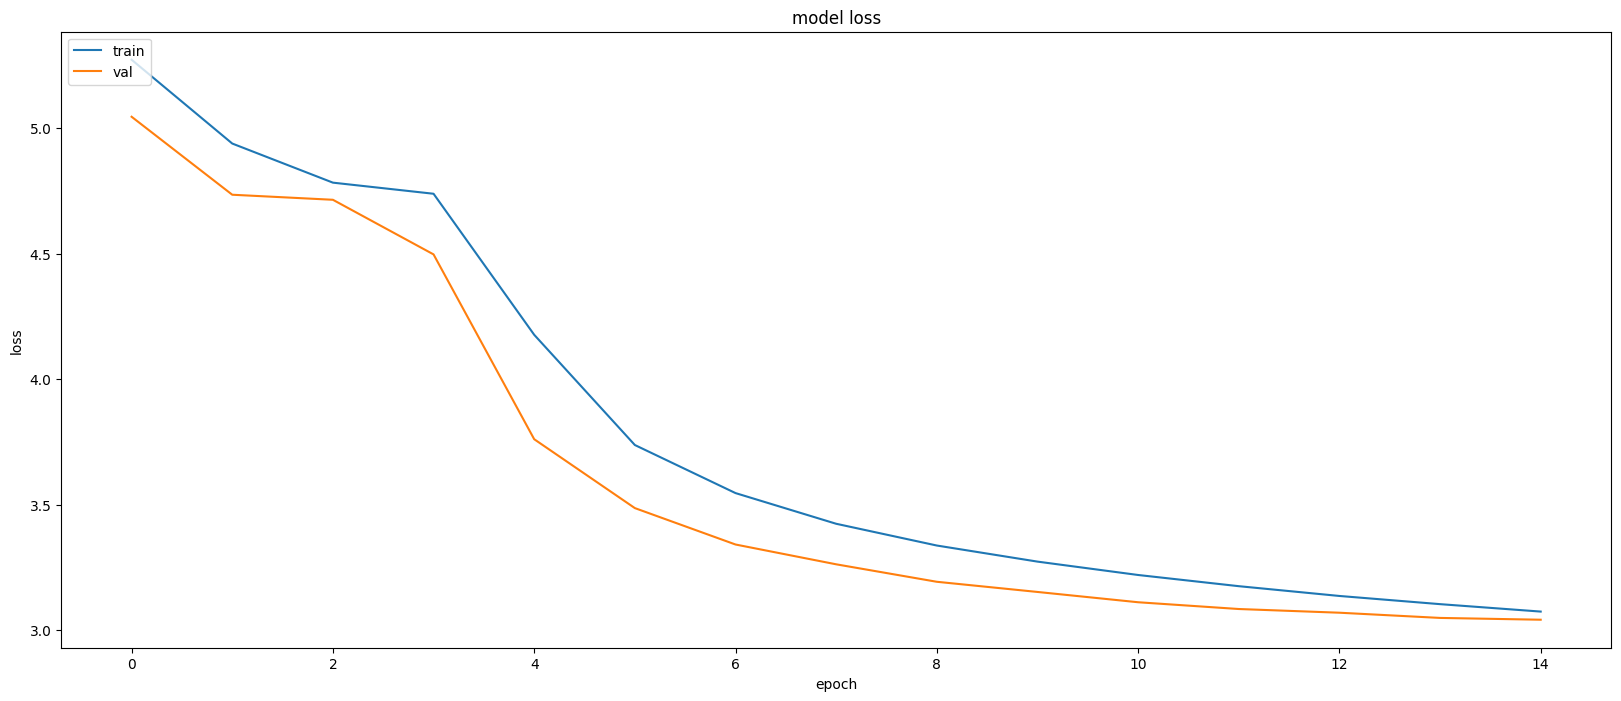

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pickle.dump(cap_model , open('/kaggle/working/cap_model.pk1' , 'wb'))

In [ ]:
cap_model = pickle.load(open('/content/drive/MyDrive/DAT450/cap_model.pk1' , 'rb'))

ValueError: Layer 'dense_6' expected 2 variables, but received 0 variables during loading. Expected: ['dense_6/kernel:0', 'dense_6/bias:0']

## 4.3 load trained model

In [ ]:
from keras.models import load_model

model_file_path = '/content/drive/MyDrive/cap_model_8k.h5'

loaded_model = load_model(model_file_path)
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 256)                  491776    ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 42)]                 0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 1, 256)               0         ['dense_3[0][0]']             
                                                                                            

# 5 Decoding Predictions

- Greedy
- top-k sampling
- Beam Search

In [ ]:
def prediction(cap_model, preprocessor, img_id, img_feature, max_len, method, k = None):

    if method == 'greedy':
        # read the input image
        feature = img_feature[img_id]
        start_seq = [preprocessor.vocab[start]]
        sentence = []
        for i in range(max_len):
            seq = [start_seq + [preprocessor.vocab[pad]]* (42 - len(start_seq))]
            #print(seq)
            pred = cap_model.predict((feature, np.array(seq)), verbose=0)
            pred_idx = np.argmax(pred)
            if pred_idx == preprocessor.vocab[end] or pred_idx is None:
                break
            start_seq.append(pred_idx)
        intermediate_caption = [preprocessor.reverse[i] for i in start_seq]
        final_caption = []

        for i in intermediate_caption:
            if i != '<end>':
                final_caption.append(i)
            else:
                break

        final_caption = ' '.join(final_caption[1:])
        #predicted_caption = ' '.join([preprocessor.reverse[word_index] for word_index in start_seq if word_index not in [preprocessor.vocab[start], preprocessor.vocab[end]]])
        print(final_caption)
        return final_caption

    elif method == 'topk':
        if k is None:
          print('Please input k.')
          return 0
        else:
          # read the input image
          feature = img_feature[img_id]
          start_seq = [preprocessor.vocab[start]]
          sentence = []
          for i in range(max_len):
            seq = [start_seq + [preprocessor.vocab[pad]]* (42 - len(start_seq))]
            #print(seq)
            pred = cap_model.predict((feature, np.array(seq)), verbose=0)[0]
            pred_idx_k = np.argsort(pred)[-k:]
            random_idx = np.random.randint(k)
            pred_idx = pred_idx_k[random_idx]
            if pred_idx == preprocessor.vocab[end] or pred_idx is None:
              break
            start_seq.append(pred_idx)

        intermediate_caption = [preprocessor.reverse[i] for i in start_seq]
        final_caption = []

        for i in intermediate_caption:
            if i != '<end>':
                final_caption.append(i)
            else:
                break

        final_caption = ' '.join(final_caption[1:])
        #predicted_caption = ' '.join([preprocessor.reverse[word_index] for word_index in start_seq if word_index not in [preprocessor.vocab[start], preprocessor.vocab[end]]])
        print(final_caption)
        return final_caption
    # Beam Search
    elif method == 'beam':
        if k is None:
            print('Please input k.')
            return 0
        else:
            # read the input image
            feature = img_feature[img_id]
            start_seq = [[[preprocessor.vocab[start]], 0.0]]#start token and initial probability
            sentence = []
            for i in range(max_len):
                temp = []
                for s in start_seq:
                    seq = pad_sequences([s[0]], maxlen=max_len, padding='post')
                    #print(seq)
                    #seq = [s[0] + [preprocessor.vocab[pad]]* (42 - len(s[0]))]
                    pred = cap_model.predict((feature, np.array(seq)), verbose=0)[0]
                    pred_idx_k = np.argsort(pred)[-k:]#top 3
                    #print(pred_idx_k)
                    for word in pred_idx_k:
                        next_cap = s[0][:]
                        prob = s[1]
                        next_cap.append(word)
                        prob += pred[word]
                        temp.append([next_cap, prob])

                start_seq = sorted(temp, reverse = False, key=lambda temp: temp[1])
                start_seq = start_seq[-k:]#current k top prob sentences
                #print(i, start_seq)

            start_seq = start_seq[-1][0] # the sentence with the highest prob
            intermediate_caption = [preprocessor.reverse[i] for i in start_seq]
            final_caption = []

            for i in intermediate_caption:
                if i != '<end>':
                    final_caption.append(i)
                else:
                    break

            final_caption = ' '.join(final_caption[1:])

            #predicted_caption = ' '.join([preprocessor.reverse[word_index] for word_index in start_seq if word_index not in [preprocessor.vocab[start], preprocessor.vocab[end]]])
            print(final_caption)
            return final_caption
            #print(predicted_caption)

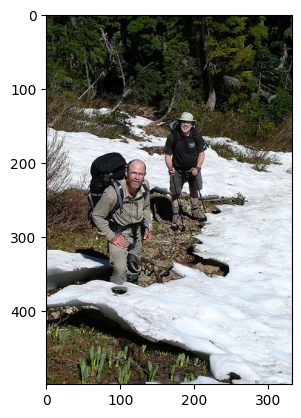

In [ ]:
test_img_id = test_df['img'][100]
test_path = '/content/data/flickr30k_images/flickr30k_images/' + test_img_id
img_eg = io.imread(test_path)
plt.imshow(img_eg)
plt.show()

In [ ]:
cap_greedy = prediction(loaded_model, preprocessor, test_img_id, test_img, max_len=42, method = 'greedy', k = None)
cap_topk = prediction(loaded_model, preprocessor, test_img_id, test_img, max_len=42, method = 'topk', k = 5)
cap_beam = prediction(loaded_model, preprocessor, test_img_id, test_img, max_len=42, method = 'beam', k = 3)

a man in a white shirt in a mountain .
people and a young young men in the mountain on a trail in a mountain with <UNKNOWN> <UNKNOWN> , on an path on their <UNKNOWN> with a trail with the <UNKNOWN> in a mountain .
a group of people are in a trail .


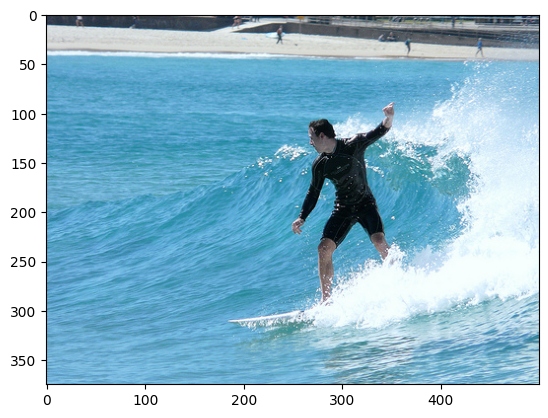

In [ ]:
random_idx = np.random.randint(len(test_df))
test_img_id = test_df['img'][random_idx]
test_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/' + test_img_id
img_eg = io.imread(test_path)
plt.imshow(img_eg)
plt.show()

In [ ]:
test_img_id

'7979221902.jpg'

In [ ]:
cap = prediction(cap_model, preprocessor, test_img_id, test_img, max_len=42, method = 'greedy', k = None)
cap = prediction(cap_model, preprocessor, test_img_id, test_img, max_len=42, method = 'topk', k = 5)
cap = prediction(cap_model, preprocessor, test_img_id, test_img, max_len=42, method = 'beam', k = 3)

a man is surfing in the ocean .


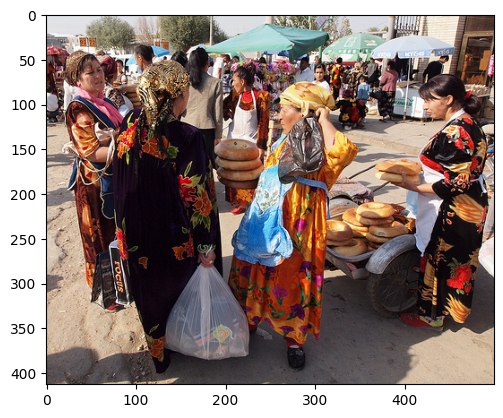

In [ ]:
random_idx = np.random.randint(len(test_df))
test_img_id = test_df['img'][random_idx]
test_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/' + test_img_id
img_eg = io.imread(test_path)
plt.imshow(img_eg)
plt.show()

In [ ]:
test_img_id

'4039390335.jpg'

In [ ]:
cap = prediction(cap_model, preprocessor, test_img_id, test_img, max_len=42, method = 'greedy', k = None)

a group of people are standing in front of a market .


In [ ]:
cap = prediction(cap_model, preprocessor, test_img_id, test_img, max_len=42, method = 'topk', k = 3)

people in front in front with <UNKNOWN> with a red <UNKNOWN> with <UNKNOWN> in the distance , with people are <UNKNOWN> . `` . `` ,


In [ ]:
cap = prediction(cap_model, preprocessor, test_img_id, test_img, max_len=42, method = 'beam', k = 3)

a group of people and a man in a red shirt are standing in front of a market .


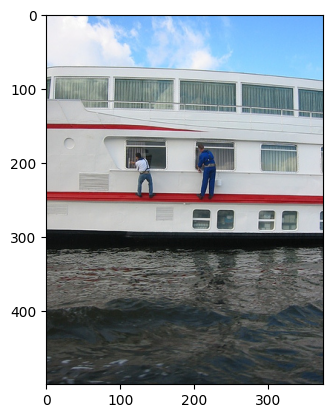

In [ ]:
random_idx = np.random.randint(len(test_df))
test_img_id = test_df['img'][random_idx]
test_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/' + test_img_id
img_eg = io.imread(test_path)
plt.imshow(img_eg)
plt.show()

In [ ]:
cap = prediction(cap_model, preprocessor, test_img_id, test_img, max_len=42, method = 'greedy', k = None)

a man is standing on a boat in a boat .


In [ ]:
cap = prediction(cap_model, preprocessor, test_img_id, test_img, max_len=42, method = 'topk', k = 3)

two people are on a boat in the water with <UNKNOWN> .


In [ ]:
cap = prediction(cap_model, preprocessor, test_img_id, test_img, max_len=42, method = 'beam', k = 3)

a man in a blue shirt is sitting on a boat .


# 6 Evaluation

The evaluation of image captioning mod- els is generally performed using metrics such as BLEU [27], METEOR [20], ROUGE [23] or CIDEr [31], all of which mainly measure the word overlap between generated and reference captions.

## 6.1 BLEU

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
def bleu(test_captions, cap):
  reference = [caption.split() for caption in test_captions]
  candidate = cap.split()

  bleu_score = []
  smoothie = SmoothingFunction().method1
  for i in range(5):
    bleu_score.append(sentence_bleu(reference[i], candidate, smoothing_function=smoothie))
  print("BLEU Score:", bleu_score)
  print("Mean BLEU Score", np.mean(bleu_score))

## 6.2 ROUGE

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge

def rouge(test_captions, cap):
  reference = [' '.join(caption.split()) for caption in test_captions]
  candidate = ' '.join(cap.split())

  rouge = Rouge()
  rouge_scores = []
  for i in range(5):
    rouge_scores.append(rouge.get_scores(candidate, reference[i]))
  print("ROUGE Scores:", rouge_scores)

## 6.3 CIDEr

In [ ]:
import copy
from collections import defaultdict
import numpy as np
import pdb
import math

def precook(s, n=4, out=False):
    """
    Takes a string as input and returns an object that can be given to
    either cook_refs or cook_test. This is optional: cook_refs and cook_test
    can take string arguments as well.
    :param s: string : sentence to be converted into ngrams
    :param n: int    : number of ngrams for which representation is calculated
    :return: term frequency vector for occuring ngrams
    """
    words = s.split()
    counts = defaultdict(int)
    for k in range(1,n+1):
        for i in range(len(words)-k+1):
            ngram = tuple(words[i:i+k])
            counts[ngram] += 1
    return counts

def cook_refs(refs, n=4): ## lhuang: oracle will call with "average"
    '''Takes a list of reference sentences for a single segment
    and returns an object that encapsulates everything that BLEU
    needs to know about them.
    :param refs: list of string : reference sentences for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (list of dict)
    '''
    return [precook(ref, n) for ref in refs]

def cook_test(test, n=4):
    '''Takes a test sentence and returns an object that
    encapsulates everything that BLEU needs to know about it.
    :param test: list of string : hypothesis sentence for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (dict)
    '''
    return precook(test, n, True)

class CiderScorer(object):
    """CIDEr scorer.
    """

    def copy(self):
        ''' copy the refs.'''
        new = CiderScorer(n=self.n)
        new.ctest = copy.copy(self.ctest)
        new.crefs = copy.copy(self.crefs)
        return new

    def __init__(self, test=None, refs=None, n=4, sigma=6.0):
        ''' singular instance '''
        self.n = n
        self.sigma = sigma
        self.crefs = []
        self.ctest = []
        self.document_frequency = defaultdict(float)
        self.cook_append(test, refs)
        self.ref_len = None

    def cook_append(self, test, refs):
        '''called by constructor and __iadd__ to avoid creating new instances.'''

        if refs is not None:
            self.crefs.append(cook_refs(refs))
            if test is not None:
                self.ctest.append(cook_test(test)) ## N.B.: -1
            else:
                self.ctest.append(None) # lens of crefs and ctest have to match

    def size(self):
        assert len(self.crefs) == len(self.ctest), "refs/test mismatch! %d<>%d" % (len(self.crefs), len(self.ctest))
        return len(self.crefs)

    def __iadd__(self, other):
        '''add an instance (e.g., from another sentence).'''

        if type(other) is tuple:
            ## avoid creating new CiderScorer instances
            self.cook_append(other[0], other[1])
        else:
            self.ctest.extend(other.ctest)
            self.crefs.extend(other.crefs)

        return self
    def compute_doc_freq(self):
        '''
        Compute term frequency for reference data.
        This will be used to compute idf (inverse document frequency later)
        The term frequency is stored in the object
        :return: None
        '''
        for refs in self.crefs:
            # refs, k ref captions of one image
            for ngram in set([ngram for ref in refs for (ngram,count) in ref.items()]):
                self.document_frequency[ngram] += 1
            # maxcounts[ngram] = max(maxcounts.get(ngram,0), count)

    def compute_cider(self):
        def counts2vec(cnts):
            """
            Function maps counts of ngram to vector of tfidf weights.
            The function returns vec, an array of dictionary that store mapping of n-gram and tf-idf weights.
            The n-th entry of array denotes length of n-grams.
            :param cnts:
            :return: vec (array of dict), norm (array of float), length (int)
            """
            vec = [defaultdict(float) for _ in range(self.n)]
            length = 0
            norm = [0.0 for _ in range(self.n)]
            for (ngram, term_freq) in cnts.items():
                # give word count 1 if it doesn't appear in reference corpus
                df = np.log(max(1.0, self.document_frequency[ngram]))
                # ngram index
                n = len(ngram)-1
                # tf (term_freq) * idf (precomputed idf) for n-grams
                vec[n][ngram] = float(term_freq)*(self.ref_len - df)
                # compute norm for the vector.  the norm will be used for computing similarity
                norm[n] += pow(vec[n][ngram], 2)

                if n == 1:
                    length += term_freq
            norm = [np.sqrt(n) for n in norm]
            return vec, norm, length

        def sim(vec_hyp, vec_ref, norm_hyp, norm_ref, length_hyp, length_ref):
            '''
            Compute the cosine similarity of two vectors.
            :param vec_hyp: array of dictionary for vector corresponding to hypothesis
            :param vec_ref: array of dictionary for vector corresponding to reference
            :param norm_hyp: array of float for vector corresponding to hypothesis
            :param norm_ref: array of float for vector corresponding to reference
            :param length_hyp: int containing length of hypothesis
            :param length_ref: int containing length of reference
            :return: array of score for each n-grams cosine similarity
            '''
            delta = float(length_hyp - length_ref)
            # measure consine similarity
            val = np.array([0.0 for _ in range(self.n)])
            for n in range(self.n):
                # ngram
                for (ngram,count) in vec_hyp[n].items():
                    # vrama91 : added clipping
                    val[n] += min(vec_hyp[n][ngram], vec_ref[n][ngram]) * vec_ref[n][ngram]

                if (norm_hyp[n] != 0) and (norm_ref[n] != 0):
                    val[n] /= (norm_hyp[n]*norm_ref[n])

                assert(not math.isnan(val[n]))
                # vrama91: added a length based gaussian penalty
                val[n] *= np.e**(-(delta**2)/(2*self.sigma**2))
            return val

        # compute log reference length
        self.ref_len = np.log(float(len(self.crefs)))
        if len(self.crefs) == 1:
            self.ref_len = 1
        scores = []
        for test, refs in zip(self.ctest, self.crefs):
            # compute vector for test captions
            vec, norm, length = counts2vec(test)
            # compute vector for ref captions
            score = np.array([0.0 for _ in range(self.n)])
            for ref in refs:
                vec_ref, norm_ref, length_ref = counts2vec(ref)
                score += sim(vec, vec_ref, norm, norm_ref, length, length_ref)
            # change by vrama91 - mean of ngram scores, instead of sum
            score_avg = np.mean(score)
            # divide by number of references
            score_avg /= len(refs)
            # multiply score by 10
            score_avg *= 10.0
            # append score of an image to the score list
            scores.append(score_avg)
        return scores

    def compute_score(self, option=None, verbose=0):
        # compute idf
        self.compute_doc_freq()
        # assert to check document frequency
        assert(len(self.ctest) >= max(self.document_frequency.values()))
        # compute cider score
        score = self.compute_cider()
        # debug
        # print score
        return np.mean(np.array(score)), np.array(score)

In [ ]:
import pdb

class Cider:
    """
    Main Class to compute the CIDEr metric

    """
    def __init__(self, test=None, refs=None, n=4, sigma=6.0):
        # set cider to sum over 1 to 4-grams
        self._n = n
        # set the standard deviation parameter for gaussian penalty
        self._sigma = sigma

    def compute_score(self, gts, res):
        """
        Main function to compute CIDEr score
        :param  hypo_for_image (dict) : dictionary with key <image> and value <tokenized hypothesis / candidate sentence>
                ref_for_image (dict)  : dictionary with key <image> and value <tokenized reference sentence>
        :return: cider (float) : computed CIDEr score for the corpus
        """

        assert(gts.keys() == res.keys())
        imgIds = gts.keys()

        cider_scorer = CiderScorer(n=self._n, sigma=self._sigma)

        for id in imgIds:
            hypo = res[id]
            ref = gts[id]

            # Sanity check.
            assert(type(hypo) is list)
            assert(len(hypo) == 1)
            assert(type(ref) is list)
            assert(len(ref) > 0)

            cider_scorer += (hypo[0], ref)

        (score, scores) = cider_scorer.compute_score()

        return score, scores

    def method(self):
        return "CIDEr"

In [ ]:
def cider(test_captions, cap, test_img_id):
  cider_scorer = Cider()
  cider_scores = []
  for i in range(5):
    _, scores = cider_scorer.compute_score({test_img_id: [test_captions[i]]}, {test_img_id: [cap]})
    cider_scores.append(scores)
  mean_score, _ = cider_scorer.compute_score({test_img_id: test_captions}, {test_img_id: [cap]})
  print("Mean CIDEr Score:", mean_score)
  print("Individual CIDEr Scores:", cider_scores)



## 6.4 Test evaluation

In [ ]:
test_img_id

'1021293940.jpg'

In [ ]:
cap_greedy

'a man in a white shirt in a mountain .'

In [ ]:
cap_topk

'people and a young young men in the mountain on a trail in a mountain with <UNKNOWN> <UNKNOWN> , on an path on their <UNKNOWN> with a trail with the <UNKNOWN> in a mountain .'

In [ ]:
cap_beam

'a group of people are in a trail .'

In [ ]:
test_captions = test_df[test_df['img'] == '1021293940.jpg']['caption'].tolist()

test_captions

[' Two men are hiking in a forest where snow is partially covering the ground .',
 ' Two men hiking in the snowy wilderness .',
 ' Two hikers resting by a patch of snow .',
 ' Two men look up while hiking .',
 ' Two men hiking in the snow .']

In [ ]:
print("Greedy:")
bleu(test_captions, cap_greedy)
print("Top-k Sampling,:")
bleu(test_captions, cap_topk)
print("Beam Search:")
bleu(test_captions, cap_beam)

Greedy:
BLEU Score: [0.02777619034011792, 0.021105340631872645, 0.025098621243978974, 0.021105340631872645, 0.021105340631872645]
Mean BLEU Score 0.023238166695942964
Top-k Sampling,:
BLEU Score: [0.006990006728332351, 0.005311256555131655, 0.0063161840849674045, 0.005311256555131655, 0.005311256555131655]
Mean BLEU Score 0.005847992095738944
Beam Search:
BLEU Score: [0.03155984539112946, 0.02145851237135921, 0.028517539529041507, 0.023980296761827107, 0.023980296761827107]
Mean BLEU Score 0.025899298163036884


In [ ]:
print("Greedy:")
rouge(test_captions, cap_greedy)
print("Top-k Sampling,:")
rouge(test_captions, cap_topk)
print("Beam Search:")
rouge(test_captions, cap_beam)

Greedy:
ROUGE Scores: [[{'rouge-1': {'r': 0.14285714285714285, 'p': 0.3333333333333333, 'f': 0.19999999580000008}, 'rouge-2': {'r': 0.07692307692307693, 'p': 0.14285714285714285, 'f': 0.09999999545000023}, 'rouge-l': {'r': 0.14285714285714285, 'p': 0.3333333333333333, 'f': 0.19999999580000008}}], [{'rouge-1': {'r': 0.14285714285714285, 'p': 0.16666666666666666, 'f': 0.1538461488757398}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.14285714285714285, 'p': 0.16666666666666666, 'f': 0.1538461488757398}}], [{'rouge-1': {'r': 0.125, 'p': 0.16666666666666666, 'f': 0.14285713795918387}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.125, 'p': 0.16666666666666666, 'f': 0.14285713795918387}}], [{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}], [{'rouge-1': {'r': 0.16666666666666666, 'p': 0.16666666666666666, 'f': 0.16666666166666683}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'roug

In [ ]:
print("Greedy:")
cider(test_captions, cap_greedy, test_img_id)
print("Top-k Sampling,:")
cider(test_captions, cap_topk, test_img_id)
print("Beam Search:")
cider(test_captions, cap_beam, test_img_id)

Greedy:
Mean CIDEr Score: 0.3672218511949174
Individual CIDEr Scores: [array([0.46489769]), array([0.39414978]), array([0.38741874]), array([0.19654768]), array([0.39309536])]
Top-k Sampling,:
Mean CIDEr Score: 0.0003447120788410727
Individual CIDEr Scores: [array([0.00167528]), array([2.03685023e-05]), array([1.41553381e-05]), array([3.58138293e-06]), array([1.01747316e-05])]
Beam Search:
Mean CIDEr Score: 0.5406814095302392
Individual CIDEr Scores: [array([0.61546288]), array([0.52565016]), array([0.75377836]), array([0.26950522]), array([0.53901043])]
